In [1]:
import numpy as np
#import cv2
framerate = 29.18
from scipy import signal
from scipy.signal import argrelextrema

import matplotlib.pyplot as plt
from scipy.signal import find_peaks
#%cd "D:\Interfacial Waves resonance videos 0430"

## Frozen frequencies

In [3]:

frozenFreqs = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/measured/frequencies.txt')
noRampVids = ['06V', '07V', '075V', '08V', '085V', '09V', '1V' , '11V', '12V', '125V', '13V', '135V', '14V', '145V', '15V']

Resonance = []
for v in noRampVids:
    plt.clf()
    ampl = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/measured/movingAvg/%s.txt' %v)
    width = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/measured/movingAvg/%sWidth.txt' %v)
    Resonance.append([np.max(ampl), np.max(width)])
Resonance = np.array(Resonance)
frozenFreqs = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/measured/frequencies.txt')
noRampVids = ['06V', '07V', '075V', '08V', '085V', '09V', '1V' , '11V', '12V', '125V', '13V', '135V', '14V', '145V', '15V']

surfaceResonance = []
for v in noRampVids:
    plt.clf()
    n = 10
    ampl = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/timeseries/surfaceresponse/%s' %v, skiprows=2)
    amplM = np.convolve(ampl[:,1], np.ones((n,))/n, mode='same')
    surfaceResonance.append([np.max(amplM)])
surfaceResonance = np.array(surfaceResonance)


<Figure size 432x288 with 0 Axes>

In [4]:
def read_file(src):
    img = cv2.flip(cv2.imread(src, cv2.IMREAD_GRAYSCALE), -1)
    return img

def printMaxAmpl(img, ref, col, loc):
    #img = img[120:515, loc[0]:loc[1]]
    #ref = ref[180:550, 600:700]
    #cv2.equalizeHist(img)
    #return locateInterface(img, maxplace, col)
    
    img = img[100:550, loc[0]:loc[1]]
    #ref = ref[180:550, 600:700]
    cv2.equalizeHist(img)

    cv2.equalizeHist(ref)
    imgref = img[:,col]
    refref = ref[:,col]
    peaksimg, _ = find_peaks(normalize(255.-imgref), height=1.25)
    peaks, _ = find_peaks(normalize(255.-refref), height=0.9)

    shorter =  np.min([len(peaksimg), len(peaks)])
    peaksimgcut = peaksimg
    peakscut = peaks[:shorter]
    maxplace = np.argmax(np.abs(np.diff(np.diff(peaksimgcut))))
    place = peaksimg[1:][maxplace]
    width = np.max(np.abs(np.diff(np.diff(peaksimgcut))))
    return [place, width]


def filterOnce(original):
    filtered = original.copy()
    avg = np.average(original)
    std = np.std(original)

    divs = np.abs(original-avg)> 2.5*std
    index = np.arange(0, len(original), 1)
    filtered[index[divs]] = filtered[index[divs]-1]
    #print(np.sum(divs))
    return filtered

def filterUntilSmooth(original):
    filtered = original.copy()
    avg = np.average(original)
    std = np.std(original)
    div = np.abs(original-avg) > 2.5*std
    while(np.sum(div)>0):
        filtered = filterOnce(filtered)
        avg = np.average(filtered)
        std = np.std(filtered)
        div = np.abs(filtered-avg)>2.5*std
    return filtered

def normalize(timeseries):
    avg = np.average(timeseries)
    stdev = np.std(np.abs(timeseries))
    return (timeseries-avg)/stdev

In [5]:
mediumRamp = np.loadtxt('data0430/MediumRamp.dat')
reverseRamp = np.loadtxt('data0430/reverseRamp.dat')
quickRamp = np.loadtxt('data0430/quickRamp.dat')
slowRamp = np.loadtxt('data0430/slowRamp.dat')

- mediumramp: in sync
- reverse ramp: in sync
- slow ramp: driving +2 sec


In [36]:
ramps = ['quickRamp', 'slowRamp','mediumRamp', 'reverseRamp']
data = [quickRamp, slowRamp, mediumRamp, reverseRamp]
allData = {}
from scipy.optimize import curve_fit
def lin(x, a,b):
    return x*a+b

for i,e in enumerate(ramps):
    dictionary = {}
    driving = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0430/driving/%s' %e, skiprows=2)
    surface = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0430/surfaceresponse/%s' %e, skiprows=2)
    dictionary['surface'] = surface
    fr = 1/(driving[1,0]-driving[0,0]) ##framerate
    from scipy import signal

    f, t, Zxx = signal.stft(driving[:,1], fr, nperseg=200,noverlap=199, detrend='constant')
    dictionary['f'] = f
    dictionary['t'] = t
    
    dictionary['Zxx'] = Zxx
    dictionary['frequencies'] = f[np.argmax(np.abs(Zxx), axis=0)]
    popt, pcov = curve_fit(lin, t, dictionary['frequencies'])
    dictionary['coeffs'] = popt
    N = int(20*framerate)
    movingAvgI = np.convolve(data[i][:,0], np.ones((N,))/N, mode='same')
    movingAvgw = np.convolve(data[i][:,1], np.ones((N,))/N, mode='same')
    dictionary['movingAvg'] = movingAvgI
    dictionary['movingAvgw'] = movingAvgw
    dictionary['time'] = np.arange(0., data[i].shape[0],1)/framerate
    allData[e] = dictionary
    
    
    

In [37]:
def plotSpectrum(e):
    plt.clf()
    f, axes = plt.subplots(3, 2)
    plottime = allData[e]['time'][N:-N]
    
    axes[0][0].plot(allData[e]['surface'][:,0], normalize(allData[e]['surface'][:,1]), '-o', markersize=1, c='black')
    axes[0][0].set_xlabel('Time')
    axes[0][0].set_ylabel('Water Surface position [px]')
    axes[0][0].set_title('Surface response')
    
    axes[1][0].plot(plottime, normalize(allData[e]['movingAvg'][N:-N]),'-o', markersize=1, c='black')
    axes[1][0].set_xlabel('Time')
    axes[1][0].set_ylabel('Interface Position [px]')
    axes[1][0].set_title('Interface response')
    
    axes[0][1].plot(lin(allData[e]['surface'][:,0], *allData[e]['coeffs']),  normalize(allData[e]['surface'][:,1]), 'o', markersize=1, c='black')
    #axes[0][1].plot(frequencies, normalize(surfaceRes[:,1]), 'o', markersize=5, c='Crimson')
    axes[0][1].set_ylabel('Surface position')
    axes[0][1].set_xlabel('Driving frequency [Hz]')
    axes[0][1].plot(frozenFreqs, normalize(surfaceResonance), 'o', markersize=5, c='Crimson')
    axes[0][1].set_ylim(axes[0][0].get_ylim())
    axes[0][1].set_title('Driving: f(t)=%s t+%s' %(round(allData[e]['coeffs'][0], 5),  round(allData[e]['coeffs'][1], 3)))

    #axes[0][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
    #axes[0][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')
    #axes[0][1].legend(loc='upper left')

    axes[1][1].plot(lin(plottime, *allData[e]['coeffs']),  normalize(allData[e]['movingAvg'][N:-N]), 'o', markersize=1, c='black')
    axes[1][1].plot(frozenFreqs, normalize(Resonance[:,0]), 'o', markersize=5, c='Crimson')
    axes[1][1].set_ylim(axes[1][0].get_ylim())
    #axes[1][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
    #axes[1][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')

    axes[1][1].set_ylabel('Interface position')
    axes[1][1].set_xlabel('Driving frequency [Hz]')


    axes[2][0].plot(plottime, normalize(allData[e]['movingAvgw'][N:-N]),'-o', markersize=1, c='black')
    axes[2][0].set_ylabel('Interface Width')
    axes[2][0].set_xlabel('Time')

    axes[2][1].plot(lin(plottime, *allData[e]['coeffs']),  normalize(allData[e]['movingAvgw'][N:-N]), 'o', markersize=1, c='black')
    axes[2][1].plot(frozenFreqs, normalize(Resonance[:,1]), 'o', markersize=5, c='Crimson')

    axes[2][1].set_ylim(axes[2][0].get_ylim())
    #axes[2][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
    #axes[2][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')


    axes[2][1].set_ylabel('Interface width')
    axes[2][1].set_xlabel('Driving frequency [Hz]')


    f.set_size_inches((13, 8))
    f.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

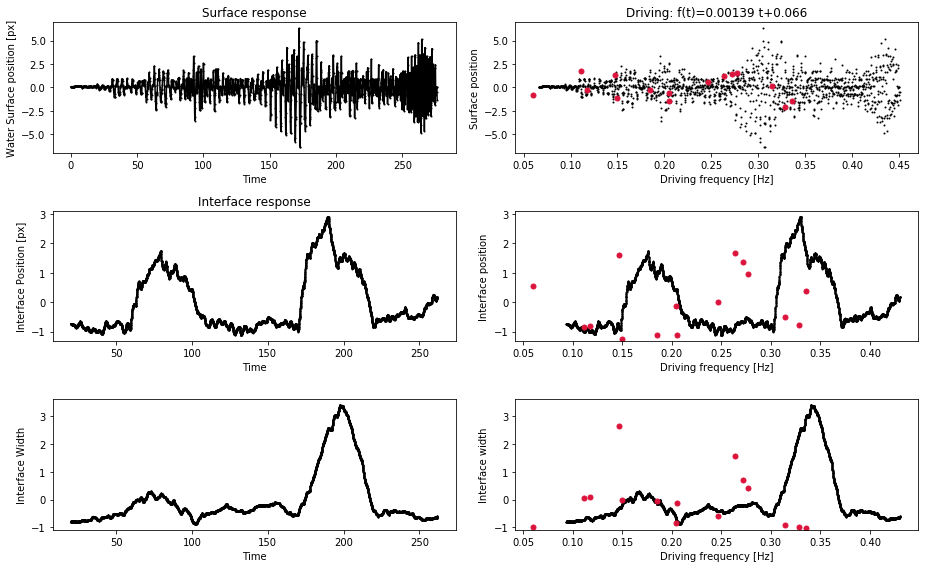

<Figure size 432x288 with 0 Axes>

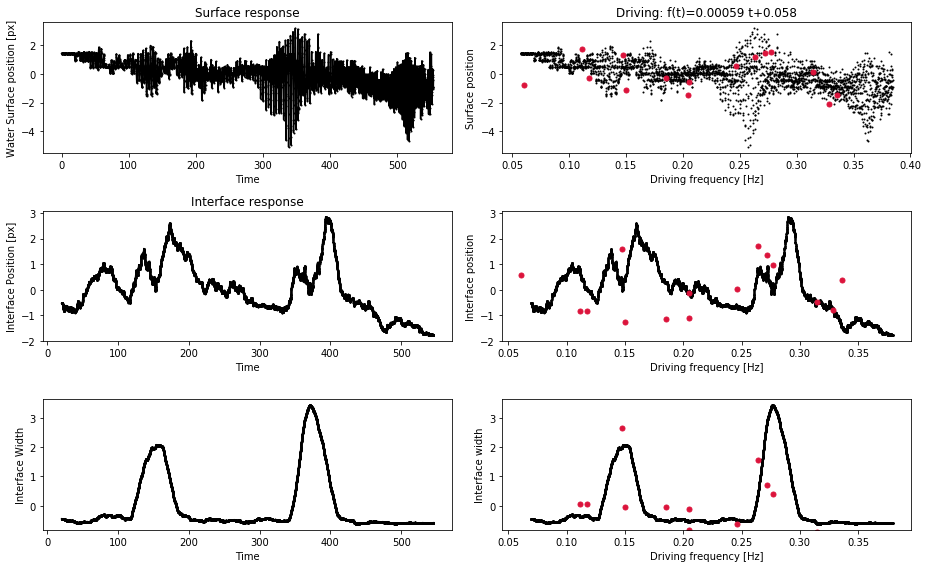

<Figure size 432x288 with 0 Axes>

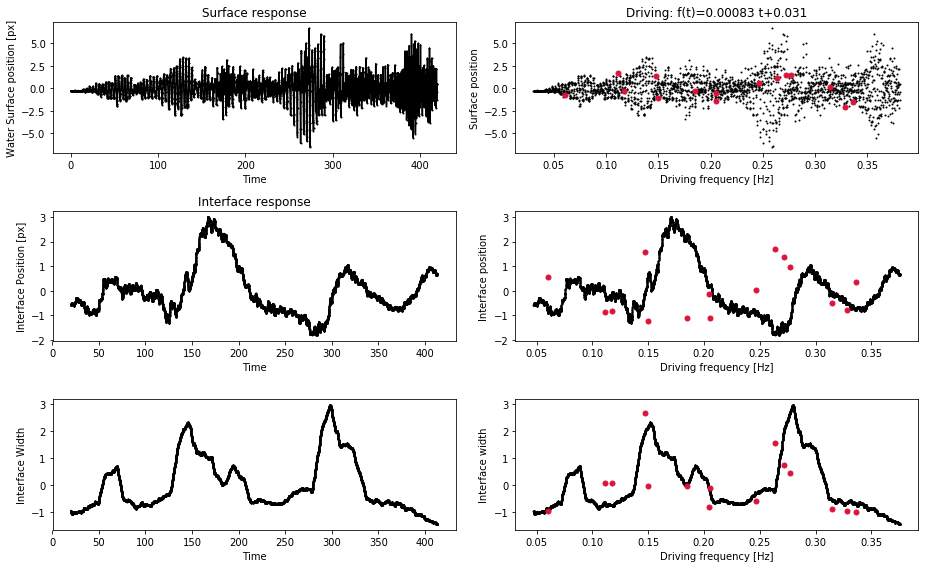

<Figure size 432x288 with 0 Axes>

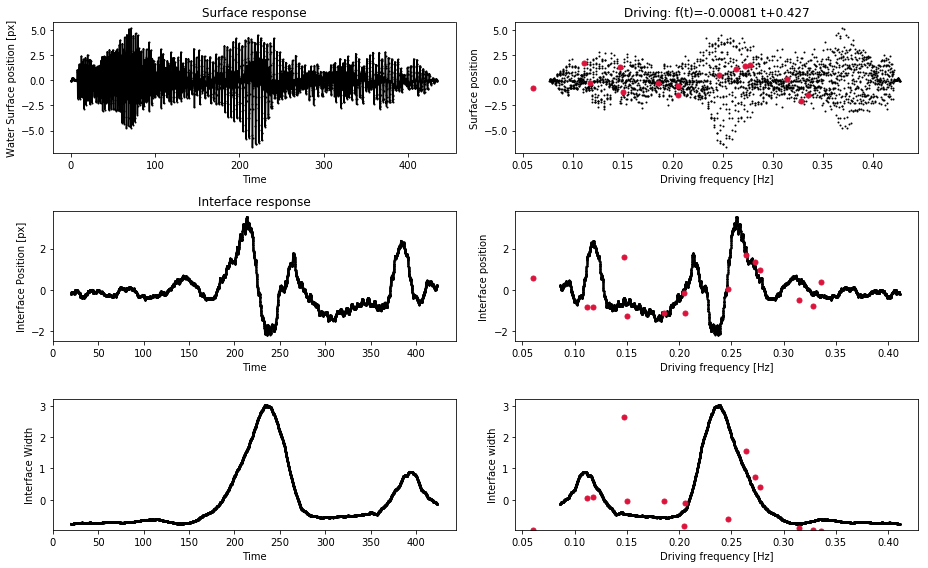

In [38]:
for e in ramps:
    plotSpectrum(e)

## Maximal interface width

In [48]:
def getMax(e):
    maxPlace = np.argmax(allData[e]['movingAvgw'])
    maxValue = np.max(normalize(allData[e]['movingAvgw']))
    maxFreq = lin(allData[e]['time'][maxPlace], *allData[e]['coeffs'])
    return [maxFreq, maxValue, allData[e]['coeffs'][0]]

In [49]:
maxWidthPlaces = []
for e in ramps:
    maxWidthPlaces.append(getMax(e))

In [50]:
maxWidthPlaces = np.array(maxWidthPlaces)

Text(0, 0.5, 'Amplitude')

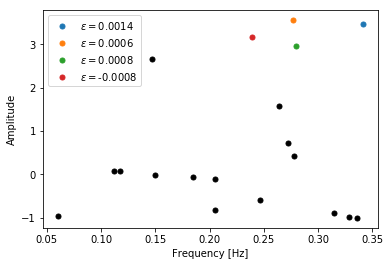

In [54]:
plt.plot(frozenFreqs, normalize(Resonance[:,1]), 'o', markersize=5, c='Black')
for e in maxWidthPlaces:
    
    plt.plot(e[0], e[1], 'o', markersize=5, label='$\epsilon = $%s' %round(e[2], 4))
plt.legend(loc='upper left')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

### Resonance frequency as a function of the rate

Text(0, 0.5, 'Resonance frequency')

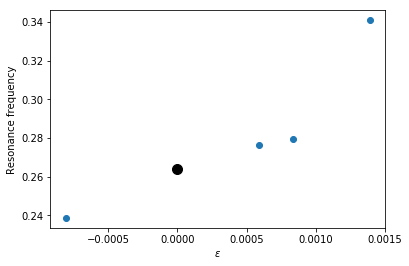

In [63]:
plt.plot(maxWidthPlaces[:,2], maxWidthPlaces[:,0], 'o')
plt.plot(0, frozenFreqs[-6], 'o', c='Black', markersize=10)
plt.xlabel('$\epsilon$')
plt.ylabel('Resonance frequency')